# CMAPSS Dataset DS02 - Utils


Please run the following cell to load all the packages required in this notebook. 

In [1]:
import os
import sys
import h5py
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from keras import backend as K
from keras.models import model_from_json

Using TensorFlow backend.


**Auxiliary functions:**

In [2]:
def plot_variables(data, figsize=10, option='idx', labelsize=16):
    """
    """
    plt.clf()
    
    input_dim = len(data[0]['variables'])
    cols = min(np.floor(input_dim**0.5).astype(int),4)
    rows = (np.ceil(input_dim / cols)).astype(int)
    gs   = gridspec.GridSpec(rows, cols)
    fig  = plt.figure(figsize=(figsize, max(figsize, rows*2)))       
    
    # Plot dataset types
    for n in range(input_dim):
        ax = fig.add_subplot(gs[n])
        # Plot only units lines
        for jj in data[0]['ds_name']:
            ax.plot(data[0][jj]['x'], data[0][jj]['y'][:,n], markeredgewidth=0.25, markersize=8)
                          
        # Adjusments
        if (y_min !=None) & (y_max !=None):
            ax.set_ylim(y_min, y_max)
        if x_max !=None:    
            ax.set_xlim(0, x_max)
        ax.tick_params(axis='x', labelsize=labelsize)
        ax.tick_params(axis='y', labelsize=labelsize)
        plt.ylabel(data[0]['label'][n], fontsize=labelsize)
        
        # Labels and legend
        if option=='idx':
            plt.xlabel('Time [t]', fontsize=labelsize)
        else:
            plt.xlabel('Time [cycles]', fontsize=labelsize)    
        plt.legend(data[0]['legend'], fontsize=labelsize-2, loc='lower left')
    
    plt.tight_layout()
    plt.show()
    plt.close()
    
def plot_predicted_true_rul(log_y_hat_test, unit_sel, Unit_test, C_test, rul_test):

    for i in range(len(log_y_hat_test)):
        fig = plt.figure(figsize=(9, 7))
        leg = []
        
        # Plot predicted RUL
        for j in unit_sel:
            y_hat_mean, y_hat_max, y_hat_min = [], [], []
            unit = Unit_test == j  
            c_test = np.sort(C_test[unit])-1
            idx = np.argsort(C_test[unit])
            y_hat_test = log_y_hat_test[i][unit]
            y_hat_test_sorted = y_hat_test[idx]
            for k in np.unique(c_test):
                y_hat_mean.append(np.mean(y_hat_test_sorted[c_test == k]))
                y_hat_max.append(np.max(y_hat_test_sorted[c_test == k]))
                y_hat_min.append(np.min(y_hat_test_sorted[c_test == k]))
            y_hat_mean = np.array(y_hat_mean, dtype=np.float64)
            y_hat_max = np.array(y_hat_max, dtype=np.float64)
            y_hat_min = np.array(y_hat_min, dtype=np.float64)
            plt.plot(np.unique(c_test), y_hat_mean, 'o', alpha=0.7, markersize=5)
            plt.fill_between(np.unique(c_test), y_hat_min, y_hat_max, alpha=0.3)
            leg.append('Unit ' + str(j))
        
        # Plot true RUL
        plt.gca().set_prop_cycle(None)
        for j in unit_sel:        
            unit = Unit_test == j  
            c_test_unique = np.unique(np.sort(C_test[unit])-1)
            rul_test_unique = np.unique(rul_test[unit])
            plt.plot(c_test_unique, rul_test_unique[::-1], alpha=0.7)           
            leg.append('True-Unit ' + str(j))
        plt.legend(leg, loc='upper right')
        plt.ylabel(r'Predicted & True $RUL$ [cycles]')
        plt.xlabel('Time [cycles]')
        plt.ylim(top=90)
    
def score_cal(y_hat, Y_test):
    d = y_hat - Y_test
    d.ravel()
    score = []
    for i in range(d.shape[0]):
        if d[i] >= 0:
            score.append(np.exp(d[i]/10) - 1)
        else:
            score.append(np.exp(-d[i]/13) - 1)
    return np.array(score)

## Load Training and Test Data

In [8]:
TEST = '/data'
PATH_IN = TEST
SOURCE = 'CMAPSS_Dataset_DS02_Assigment'

#def load_data(PATH_IN, SOURCE)
 
# Time tracking, Operation time (min):  0.004
t = time.clock()

# Variable name
varname = ['alt', 'Mach', 'TRA', 'T2',
          'T24', 'T30', 'T40', 'T48', 'T50', 
          'P15', 'P2', 'P21', 'P24', 'Ps30', 'P30', 'P40', 'P50',
          'Nf', 'Nc', 'Wf',
          'HPT_eff_mod', 'LPT_eff_mod', 'LPT_flow_mod']

with h5py.File(os.getcwd()+PATH_IN + "/" + SOURCE + '.h5', 'r') as hdf:
# Nominal Training set
    W_train = np.array(hdf.get('W_train'))                 # W
    X_s_train = np.array(hdf.get('X_s_train'))             # X_s
    T_train = np.array(hdf.get('T_train'))                 # T
    Y_train = np.array(hdf.get('Y_train'))                 # RUL  
    U_train = np.array(hdf.get('U_train'))                 # Units
    C_train = np.array(hdf.get('C_train'))                 # Cycles

# Nominal Test set - Past
    W_test = np.array(hdf.get('W_test'))                   # W
    X_s_test = np.array(hdf.get('X_s_test'))               # X_s
    T_test = np.array(hdf.get('T_test'))                   # T
    Y_test = np.array(hdf.get('Y_test'))                   # RUL  
    U_test = np.array(hdf.get('U_test'))                   # Units
    C_test = np.array(hdf.get('C_test'))                   # Cycles

# Nominal Test set - Future
    W_path1 = np.array(hdf.get('W_path1'))                 # W
    X_s_path1 = np.array(hdf.get('X_s_path1'))             # X_s
    T_path1 = np.array(hdf.get('T_path1'))                 # T
    Y_path1 = np.array(hdf.get('Y_path1'))                 # RUL  
    U_path1 = np.array(hdf.get('U_path1'))                 # Units
    C_path1 = np.array(hdf.get('C_path1'))                 # Cycles

# Alternative paths
    T_path2 = np.array(hdf.get('T_path2'))                 # T
    T_path3 = np.array(hdf.get('T_path3'))                 # T

# Noisy Test set
    X_s_test_db60 = np.array(hdf.get('X_s_test_db60'))     # X_s

# De-Noised Training set
    X_s_train_deno = np.array(hdf.get('X_s_train_deno'))   # X_s

# De-Noised Test set
    X_s_test_deno = np.array(hdf.get('X_s_test_deno'))     # X_s 

print('')
print("Operation time (min): " , (time.clock()-t)/60)
print('')
    

/gneven/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  



Operation time (min):  0.0675478



/gneven/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [9]:
print ("Units train set: ", np.unique(U_train))
print ("Units test set: ", np.unique(U_test))
print('')
print ("W_train shape: ", W_train.shape)
print ("W_test shape: ", W_test.shape)
print('')
print ("X_s_train shape: ", X_s_train.shape)
print ("X_s_test shape: ", X_s_test.shape)
print('')
print ("T_train shape: ", T_train.shape)
print ("T_test shape: ", T_test.shape)

Units train set:  [ 2  5 10 16 18 20]
Units test set:  [11 14 15]

W_train shape:  (526347, 4)
W_test shape:  (83135, 4)

X_s_train shape:  (526347, 16)
X_s_test shape:  (83135, 16)

T_train shape:  (526347, 3)
T_test shape:  (83135, 3)


## Part 0: Data Exploration


['HPT_eff_mod', 'LPT_eff_mod', 'LPT_flow_mod']


<Figure size 432x288 with 0 Axes>

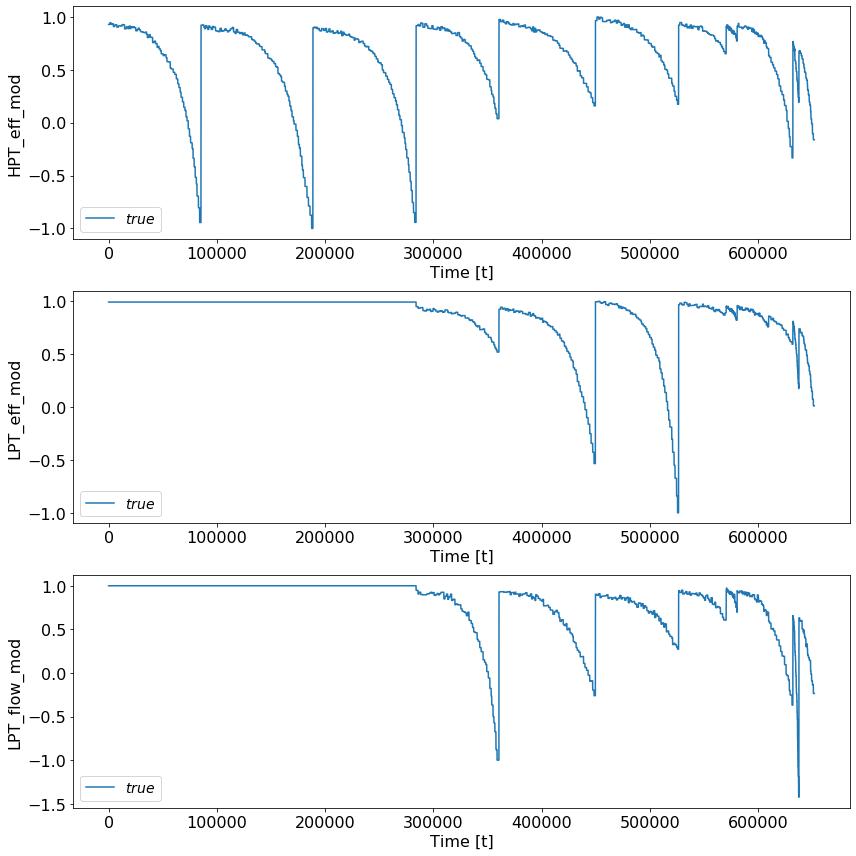

In [10]:
# Set-up
data, data[0] = {}, {}
data[0]['variables'] = varname[-3:]       # Variables names
print('')
print(data[0]['variables'])

data[0]['label'] = data[0]['variables']
data[0]['legend'] = ['$true$']
data[0]['ds_name'] = ['true']
data[0]['option'] = 'Save'

# Data to plot
data[0]['true'], data[0]['pred'] = {}, {}
data[0]['true']['y'] = np.concatenate((T_train, T_test, T_path1))
data[0]['true']['x'] = np.arange(data[0]['true']['y'].shape[0])

# Plot limits
x_max = None              # Max x
y_min = None              # Min y
y_max = None              # Max y

# Plot
plot_variables(data, figsize=12, option='idx')

<IPython.core.display.Javascript object>


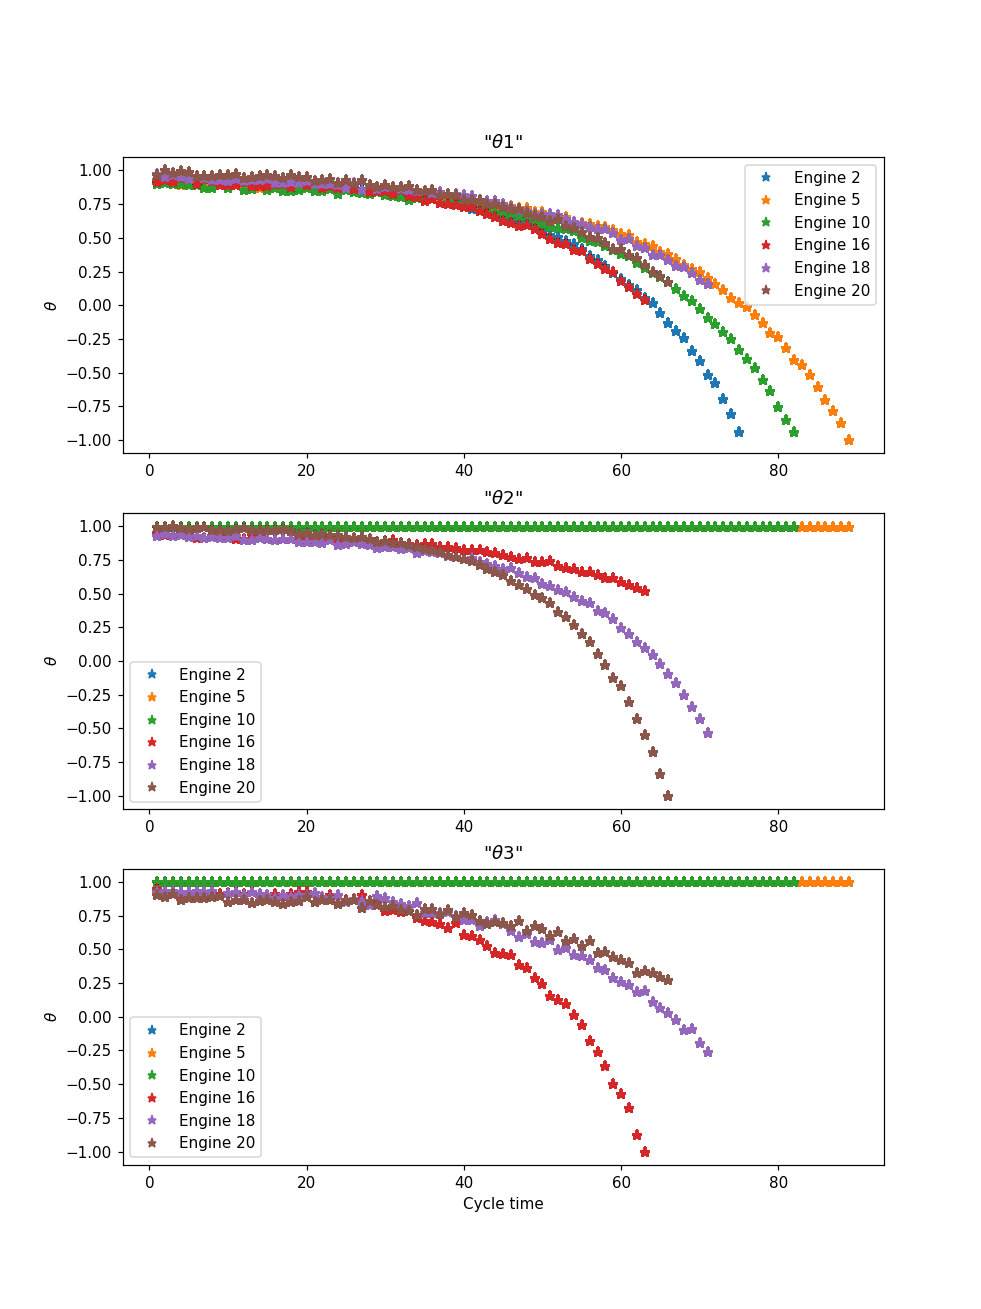

[Text(0, 0.5, '$\\theta$'),
 Text(0.5, 0, 'Cycle time'),
 Text(0.5, 1.0, '"$\\theta 3$"')]

In [79]:
%matplotlib notebook
fig,axes = plt.subplots(nrows = 3, ncols = 1,figsize=(9,12))
ax1 = plt.subplot(3,1,1)
ax2 = plt.subplot(3,1,2)
ax3 = plt.subplot(3,1,3)

for u in [2,5,10,16,18,20]:
    ax1.plot(C_train[U_train == u],T_train[(U_train == u).ravel(),0]
    ,'*',label = 'Engine %i' %u)
    
    ax1.legend()
    
    ax2.plot(C_train[U_train == u],T_train[(U_train == u).ravel(),1]
    ,'*',label = 'Engine %i' %u)
    
    ax2.legend()

    ax3.plot(C_train[U_train == u],T_train[(U_train == u).ravel(),2]
    ,'*',label = 'Engine %i' %u)
    

    ax3.legend()
    
ax1.set(ylabel = "$\\theta$",title = '"$\\theta 1$"')    
ax2.set(ylabel = "$\\theta$",title = '"$\\theta 2$"')
ax3.set(xlabel='Cycle time',ylabel = "$\\theta$",title = '"$\\theta 3$"')
 
    


array([ 0.92946716,  0.92946716,  0.92946716, ..., -0.94398601,
       -0.94398601, -0.94398601])

## Part 1 - Pure Data-Driven Prognostics Model with Supervised Learning (SL) 

In [ ]:
# Set-up
MODEL_PATH = '../model'
model_sel = MODEL_PATH + '/' + 'model_FF_0'
with open(model_sel + '.json', "r") as json_file:
    loaded_model_json = json_file.read()
rul_model = model_from_json(loaded_model_json)
rul_model.load_weights(model_sel + '.h5')
print('')
print("Loaded RUL model from disk")

### a)  [15 points] Prognostics based on Condition Monitoring Data

**Predict RUL**

In [ ]:
Y_hat_test = rul_model.predict(x=np.concatenate((W_test, X_s_test), axis=-1))

**Evaluate RUL performance**

In [ ]:
scores = score_cal(Y_hat_test, Y_test)
print('')
print(r's:', np.sum(scores))
print('RMSE:', np.sqrt(np.mean((Y_hat_test - Y_test)**2)))

**Plot predicted Vs. true RUL**

In [ ]:
# True and predict vs time - Test Per engine
unit_sel = [11, 14, 15]
log_y_hat_test = [Y_hat_test]

# Plot rul
plot_predicted_true_rul(log_y_hat_test, unit_sel, U_test, C_test, Y_test)

## Part 2: Prognostics with Generated Sensor Readings $X_{s*}$

### (a)  [10 points] Generation GT Sensor Readings Given Future Trajectory.

To start off the model, we will initialize `x0` with curetn sensor readings.

Here are some of the key steps you'll need to implement inside the for-loop that generates the $T_y$ output characters: 

Step 2.A: Select `x` value according to `out` and expand `x` with `w` and `theta` i.e. `[w, out, theta]` 

Step 2.B: Perform one step of MLP network to get the output for the current step. 

Step 2.C: Save the output you have just generated by appending it to `outputs`.


In [ ]:
def gt_generative_model(model_sel, W, T, x0, n_w, n_t, n_out):
    """
    Uses the trained inference model to generate a sequence of values.
    
    Arguments:
    W -- np.array, operative conditions 
    T -- np.array, degradation condition
    x0 -- np.array, inital sensor readings
    n_w -- integer, dimensions of the operative conditions vector, w^{(t)}
    n_t -- integer, dimensions of the calibtation factors vector, \theta^{(t)}
    n_out -- integer, number of units in the ouput layer
    
    Returns:
    outputs -- np.array with predict gt_model response (i.e, $x_s$) 
    """
    
    # Set-up
    Ty = W.shape[0]
    outputs, inputs = [], [] # Create an empty list of "outputs" to later store your predicted values

    # Step 0: Define x0, initial input of the MLP
    out = x0
    
    # Step 1: Lad inference_model

        
    # Step 2: Loop over Ty and generate a value at every time step
    for t in range(Ty):
        
        # Step 2.A: Select "x" value according to "out" and expand "x" with "w" and "theta "i.e. "[w, out, theta]"
        
        # Step 2.B: Perform one step of MLP network
        
        # Step 2.C: Append the prediction "out" to "outputs". out.shape = (None, n_out)
        
    return outputs, inputs

In [ ]:
def predict_given_input(model_sel, W_gen, T_gen, x_0, n_w, n_t, n_out):
    """
    Predicts the next value of values using the generative model.
    
    Arguments:
    x_initializer -- numpy array of shape (1, n_x), input vector initializing the values generation
    W_gen -- numpy array of shape (Ty, n_w), input matrix with the w values for generation
    T_gen -- numpy array of shape (Ty, n_t), input matrix with the \theta values for generation
    
    Returns:
    results -- numpy-array of shape (Ty, 1, n_y), matrix representing the x_s values generated
    """
    
    # Step 1: Use the generative model to predict an output sequence given: W_gen, theta_gen, x_initializer.
    pred, x = gt_generative_model(model_sel, W_gen, T_gen, x_0, n_w, n_t, n_out)
    
    # Step 2: Convert "pred" into an np.array()
    results = np.array(pred)
    inputs = np.array(x)
    
    return results[:,0, :], inputs[:,0, :]

**Define Future Conditions**

In [ ]:
# Nominal future trajectories

# Set-up
n_out = X_s_path1.shape[-1]
n_w = W_path1.shape[-1]
n_t = T_path1.shape[-1]

# X0
x_gen = X_s_path1
x_0 = x_gen[1,:]
x_0.shape = (1, n_out)
print('X0 shape: ', x_0.shape)

# w
W_gen = W_path1
print('W_gen shape: ', W_gen.shape)

C_gen  = C_path1
U_gen  = U_path1

In [ ]:
T_path2.shape

In [ ]:
# Time tracking, Operation time (min):  0.4 per prediction
t = time.clock()

model_sel = MODEL_PATH + '/' + 'model' + '_h_0_run_0'

X_s_hat_inf_1, X_inf_1 = predict_given_input(model_sel, W_gen, T_path1, x_0, n_w, n_t, n_out)
X_s_hat_inf_2, X_inf_2 = predict_given_input(model_sel, W_gen, T_path2, x_0, n_w, n_t, n_out)
X_s_hat_inf_3, X_inf_3 = predict_given_input(model_sel, W_gen, T_path3, x_0, n_w, n_t, n_out)

# Report time
print("Operation time (min): " , (time.clock()-t)/60)
print('')
print ("X_s_hat_inf shape: " + str(X_s_hat_inf_1.shape))
print ("X_inf shape: " + str(X_inf_1.shape))
print('')

In [ ]:
# Unit 11
mask_11 = np.ravel((U_gen == 11))

# Unit 14
mask_14 = np.ravel((U_gen == 14))

# Unit 15
mask_15 = np.ravel((U_gen == 15))

In [ ]:
# Set-up
data, data[0] = {}, {}
data[0]['variables'] = varname[-3:]       # Variables names
print('')
print(data[0]['variables'])

data[0]['label'] = data[0]['variables']
data[0]['legend'] = ['$path_1$', '$path_2$', '$path_3$']
data[0]['ds_name'] = ['path_1', 'path_2', 'path_3']
data[0]['option'] = 'Save'

# Data to plot
data[0]['path_1'] = {}
data[0]['path_1']['y'] = T_path1[mask_14]
data[0]['path_1']['x'] = np.arange(data[0]['path_1']['y'].shape[0])

data[0]['path_2'] = {}
data[0]['path_2']['y'] = T_path2[mask_14]
data[0]['path_2']['x'] = np.arange(data[0]['path_2']['y'].shape[0])

data[0]['path_3'] = {}
data[0]['path_3']['y'] = T_path3[mask_14]
data[0]['path_3']['x'] = np.arange(data[0]['path_3']['y'].shape[0])

# Plot limits
x_max = None              # Max x
y_min = None              # Min y
y_max = None              # Max y

# Plot
plot_variables(data, figsize=12, option='idx')

In [ ]:
# Set-up
dim1, dim2 = 1000, 2000
data, data[0] = {}, {}
data[0]['variables'] = varname[4:20]       # Variables names
print('')
print(data[0]['variables'])

data[0]['label'] = data[0]['variables']
data[0]['legend'] = ['$path_1$', '$path_2$', '$path_3$']
data[0]['ds_name'] = ['path_1', 'path_2', 'path_3']
data[0]['option'] = 'Save'

# Data to plot
data[0]['path_1'] = {}
data[0]['path_1']['y'] = X_s_hat_inf_1[dim1:dim2,:] - X_s_hat_inf_1[dim1:dim2,:]
data[0]['path_1']['x'] = np.arange(data[0]['path_1']['y'].shape[0])

data[0]['path_2'] = {}
data[0]['path_2']['y'] = X_s_hat_inf_1[dim1:dim2,:] - X_s_hat_inf_2[dim1:dim2,:]
data[0]['path_2']['x'] = np.arange(data[0]['path_2']['y'].shape[0])

data[0]['path_3'] = {}
data[0]['path_3']['y'] = X_s_hat_inf_1[dim1:dim2,:] - X_s_hat_inf_3[dim1:dim2,:]
data[0]['path_3']['x'] = np.arange(data[0]['path_3']['y'].shape[0])

# Plot limits
x_max = None              # Max x
y_min = None              # Min y
y_max = None              # Max y

# Plot
plot_variables(data, figsize=12, option='idx')

###  (b)  [10 points] Prognostics with Generated Trajectories

In [ ]:
# Set-up
MODEL_PATH = 'C:/Users/arimanue/polybox/teaching/2020/model'
model_sel = MODEL_PATH + '/' + 'model_FF_0'
with open(model_sel + '.json', "r") as json_file:
    loaded_model_json = json_file.read()
rul_model = model_from_json(loaded_model_json)
rul_model.load_weights(model_sel + '.h5')
print('')
print("Loaded RUL model from disk")

**Predict RUL**

In [ ]:
rul_path_1 = rul_model.predict(x=np.concatenate((W_gen, X_s_hat_inf_1), axis=-1))
rul_path_2 = rul_model.predict(x=np.concatenate((W_gen, X_s_hat_inf_2), axis=-1))
rul_path_3 = rul_model.predict(x=np.concatenate((W_gen, X_s_hat_inf_3), axis=-1))

log_rul_path_gen  = [rul_path_1, rul_path_2, rul_path_3] 